In [2]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import regex as reg
import random

In [54]:
train_labels = pd.read_csv('Data/TrainLabels.csv')
submission = pd.read_csv('Data/SampleSubmission.csv')
true_labels = pd.read_csv('Data/true_labels.csv')

In [55]:
X_train = np.load('Data/X_train_final(bs).npy')
X_test = np.load('Data/X_test_final(bs).npy')

In [56]:
Y_train = train_labels.Prediction.values
true_labels = pd.read_csv('Data/true_labels.csv')
Y_test = true_labels['1'].values

In [57]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [58]:
training_subjects = int(16)
num_of_fb = int(340)

In [59]:
'''get_meta(labels)
Get meta data for each feedback, returns subject #, session #, and feedback #, using regex patterns

Args:
    labels: train or test labels consisting of an IdFeedBack column
    
Returns:
   subs, sess, fbs: Subjects, Sessions, and Feedbacks respectively returned as 1 dimensional array,
   meta data can be used to improve model performances. 
'''
def get_meta(labels):
    subs = []
    sess = []
    fbs = []
    for i,f in enumerate(labels.IdFeedBack.values):
        [(subject, session, feedback)] = reg.findall('S(\d\d).+s(\d\d).+FB(\d\d\d)',f)
        subs.append(int(subject)) 
        sess.append(int(session)) 
        fbs.append(int(feedback))
    return subs, sess, fbs

In [60]:
train_subs, train_sessions, train_fbs = get_meta(train_labels)
test_subs, test_sessions, test_fbs = get_meta(submission)

In [61]:
df_train = pd.DataFrame(X_train)
df_train['Subject'] = train_subs
df_train['Session'] = train_sessions
df_train['Feedback'] = train_fbs

In [62]:
df_test = pd.DataFrame(X_test)
df_test['Subject'] = test_subs
df_test['Session'] = test_sessions
df_test['Feedback'] = test_fbs

In [63]:
'''extract_sub(df_X, train_sub)
Random selection of train_sub subjects, (16 - train_sub) are the number of subjects used for test data. Use train_subs
to create train_subs random values ranging from 0 to 16, those subjects will now be training, while rest will be testing.

Args:
    df_X: DataFrame of input data, consisting of 16 total subjects, 340 feedbacks each
    train_sub: number of subjects used for training
    
Returns:
    train_x, train_y, test_x, test_y: train and test data for x and y respectively.
'''
def extract_sub(df_X, train_sub):
    train_subs = random.sample(list(np.arange(0,training_subjects)),train_sub)
    array = np.array(df_X).reshape(training_subjects,num_of_fb,df_X.shape[1])
    array_Y = Y_train.reshape(training_subjects,num_of_fb)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for j, i in enumerate(np.arange(0,training_subjects)):
        if i in train_subs:
            if len(train_x) == 0:
                train_x = array[i,:,:].reshape(num_of_fb,df_X.shape[1])
                train_y = np.append(train_y, array_Y[i,:])

            else:
                train_x = np.append(train_x, array[i,:,:].reshape(num_of_fb,df_X.shape[1]), axis = 0)
                train_y = np.append(train_y, array_Y[i,:])
        else:
            if len(test_x) == 0:
                test_x = array[i,:,:].reshape(num_of_fb,df_X.shape[1])
                test_y = np.append(test_y, array_Y[i,:])
            else:
                test_x = np.append(test_x, array[i,:,:].reshape(num_of_fb,df_X.shape[1]), axis = 0)
                test_y = np.append(test_y, array_Y[i,:])
    return train_x, train_y, test_x, test_y

In [64]:
train_x, train_y, test_x, test_y = extract_sub(df_train, 12)

In [65]:
print(train_x.shape, train_y. shape)

(4080, 213) (4080,)


In [66]:
print(test_x.shape, test_y. shape)

(1360, 213) (1360,)


In [25]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=150, random_state=42)
clf.fit(train_x, train_y)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 2 seconds


In [374]:
preds = clf.predict_proba(test_x)[:,1]

In [274]:
train_x.shape

(5100, 213)

max(tpr - fpr) w/ th =  0.6866666666666666


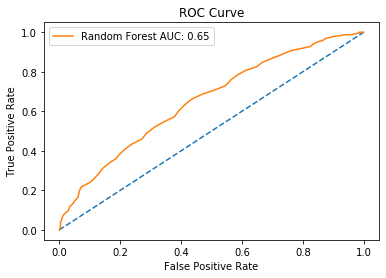

In [375]:
plot_roc(test_y, preds, 'Random Forest')

max(tpr - fpr) w/ th =  0.6933333333333334


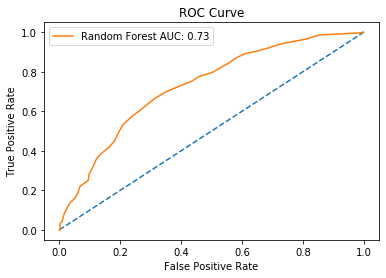

In [311]:
plot_roc(test_y, preds, 'Random Forest')

## Random Forests

In [9]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=150, random_state=42)
clf.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 2 seconds


In [10]:
preds = clf.predict_proba(x_test1)[:,1]

In [64]:
def plot_roc(y, preds, model):
    fpr, tpr, thresholds = roc_curve(y, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("max(tpr - fpr) w/ th = ", optimal_threshold)
    l1, = plt.plot([0, 1], [0, 1], '--')
    l2, = plt.plot(fpr, tpr, label = 'Random Forest')
    auc = roc_auc_score(y, preds)
    l = plt.legend([l2], [model+str(' AUC: %.2f' % auc)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

max(tpr - fpr) w/ th =  0.6533333333333333


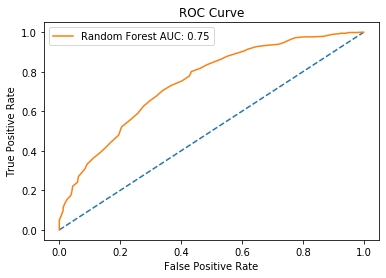

In [12]:
plot_roc(y_test1, preds, 'Random Forest')

In [399]:
params = {
    'n_estimators': [100,200,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,10,50,100]
}

In [ ]:
train_subs = random.sample(list(np.arange(0,training_subjects)),train_sub)
    array = np.array(df_X).reshape(training_subjects,num_of_fb,df_X.shape[1])
    array_Y = Y_train.reshape(training_subjects,num_of_fb)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    

In [24]:
myCV = []
train_subs = []
test_subs = []
for i in range(4):
    train_x, train_y, test_x, test_y = extract_sub(df_train, 12)
    trainIndices = train_x.index.values.astype(int)
    testIndices =  test_x.index.values.astype(int)
    myCV.append( (trainIndices, testIndices))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [38]:
df_train.values

array([[-3.05263699e-01, -3.07819663e-02, -4.71910250e-01, ...,
         2.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-2.66628725e-01, -1.81049091e-02, -4.78228377e-01, ...,
         2.00000000e+00,  1.00000000e+00,  2.00000000e+00],
       [-2.50896688e-01, -5.88883808e-02, -5.04756293e-01, ...,
         2.00000000e+00,  1.00000000e+00,  3.00000000e+00],
       ...,
       [-9.46498551e-01, -6.89467149e-02, -8.40739974e-02, ...,
         2.60000000e+01,  5.00000000e+00,  9.80000000e+01],
       [-7.75437908e-01, -1.14420645e-02, -1.26510940e-01, ...,
         2.60000000e+01,  5.00000000e+00,  9.90000000e+01],
       [-8.57468365e-01,  3.98490530e-02, -2.32000896e-02, ...,
         2.60000000e+01,  5.00000000e+00,  1.00000000e+02]])

In [ ]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42)
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=5, refit='accuracy', cv=16)
cv.fit(X_train,Y_train)

Fitting 16 folds for each of 48 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.6min


In [14]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score')['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.521680,0.365569,1.176135,0.227289,1,auto,100,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
1,2.741622,0.521117,0.675058,0.421479,1,auto,200,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
2,6.541156,0.585087,2.281829,0.771777,1,auto,500,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
3,14.225604,0.579375,1.220352,0.366931,1,auto,1000,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
4,5.372815,0.255646,1.080329,0.837969,1,sqrt,100,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
5,2.213030,0.299663,0.751772,0.193605,1,sqrt,200,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
6,5.768453,0.505435,1.282780,0.338463,1,sqrt,500,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
7,14.024614,1.085484,2.326262,0.962903,1,sqrt,1000,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
8,2.861468,1.238367,3.019022,0.874581,1,log2,100,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
9,4.580955,1.006996,1.012877,0.659329,1,log2,200,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1


In [118]:
X_train1 = np.load('Data/X_train_final2.npy')
X_test1 = np.load('Data/X_test_final2.npy')

In [376]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42, 
                                      max_depth = 1, max_features = 'auto', n_estimators = 100)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [377]:
probs = clf.predict_proba(X_test)[:,1]
probs

array([0.67920633, 0.67920633, 0.68034415, ..., 0.69085119, 0.69056741,
       0.68869196])

max(tpr - fpr) w/ th =  0.6798805018631471


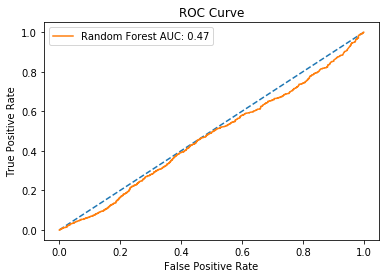

In [378]:
plot_roc(Y_test, probs[:-1], 'Random Forest')

In [18]:
def matrix_info(th, y, probs):
    preds = (probs >= th).astype(np.int)
    print('f1_score:')
    print(f1_score(y, preds))
    print('Confusion Matrix:')
    print(confusion_matrix(y,preds))
    print(classification_report(y,preds))

In [154]:
for i in np.arange(0.68,0.73,0.01):
    print(i)
    matrix_info(i, Y_train, probs)

0.68
f1_score:
0.8398450470392917
Confusion Matrix:
[[ 199 1391]
 [  56 3794]]
              precision    recall  f1-score   support

           0       0.78      0.13      0.22      1590
           1       0.73      0.99      0.84      3850

    accuracy                           0.73      5440
   macro avg       0.76      0.56      0.53      5440
weighted avg       0.75      0.73      0.66      5440

0.6900000000000001
f1_score:
0.8377735490009516
Confusion Matrix:
[[ 554 1036]
 [ 328 3522]]
              precision    recall  f1-score   support

           0       0.63      0.35      0.45      1590
           1       0.77      0.91      0.84      3850

    accuracy                           0.75      5440
   macro avg       0.70      0.63      0.64      5440
weighted avg       0.73      0.75      0.72      5440

0.7000000000000001
f1_score:
0.7824181843078187
Confusion Matrix:
[[ 994  596]
 [ 993 2857]]
              precision    recall  f1-score   support

           0       0.50   

In [158]:
matrix_info(0.68 ,Y_train, probs)

f1_score:
0.8398450470392917
Confusion Matrix:
[[ 199 1391]
 [  56 3794]]
              precision    recall  f1-score   support

           0       0.78      0.13      0.22      1590
           1       0.73      0.99      0.84      3850

    accuracy                           0.73      5440
   macro avg       0.76      0.56      0.53      5440
weighted avg       0.75      0.73      0.66      5440



C:\Users\taq19\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [154]:
submission.to_csv('submission.csv', index=None)

## Logistic Regression

In [379]:
from sklearn.linear_model import LogisticRegression

In [380]:
clf = LogisticRegression(random_state=0, max_iter=1000, C = 0.1, penalty = 'l1').fit(x_train1, y_train1)
probs = clf.predict_proba(x_test1)[:,1]

NameError: name 'x_train1' is not defined

In [122]:
probs

array([0.93160791, 0.91035478, 0.31679332, ..., 0.8560108 , 0.81947571,
       0.96769439])

max(tpr - fpr) w/ th =  0.7063613939602489


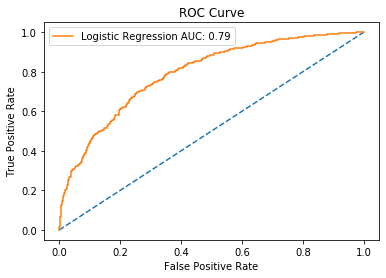

In [143]:
plot_roc(y_test1, probs, 'Logistic Regression')

In [129]:
params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2"]
}

In [130]:
clf = LogisticRegression(random_state=42, max_iter=1000)
cv = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=10, cv=4)

In [131]:
cv.fit(X_train, Y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  47 out of  56 | elapsed:    5.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    6.4s finished
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [133]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'C': 0.1, 'penalty': 'l1'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
4,0.426116,0.035696,0.007226,7.343693e-03,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.737693,0.732550,0.746137,0.731420,0.736949,0.005806,1
3,0.637098,0.055697,0.002743,4.321556e-04,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.734754,0.718589,0.740250,0.728477,0.730515,0.008049,2
2,0.289321,0.019645,0.002742,4.311920e-04,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.724467,0.731080,0.724062,0.735835,0.728860,0.004896,3
5,1.086861,0.072127,0.002241,4.339272e-04,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.736958,0.715650,0.729213,0.725533,0.726838,0.007666,4
6,0.769711,0.045774,0.002739,4.299744e-04,1,l1,"{'C': 1.0, 'penalty': 'l1'}",0.735489,0.713446,0.731420,0.722590,0.725735,0.008493,5
7,1.292467,0.197123,0.003740,1.474329e-03,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.731815,0.708303,0.727741,0.727005,0.723713,0.009088,6
10,0.979130,0.057120,0.002993,7.633119e-07,100,l1,"{'C': 100.0, 'penalty': 'l1'}",0.731080,0.709037,0.726269,0.725533,0.722978,0.008330,7
8,0.988899,0.074675,0.002742,4.317779e-04,10,l1,"{'C': 10.0, 'penalty': 'l1'}",0.731080,0.709037,0.726269,0.724798,0.722794,0.008279,8
11,1.228465,0.102194,0.003741,1.295847e-03,100,l2,"{'C': 100.0, 'penalty': 'l2'}",0.731080,0.709037,0.725533,0.725533,0.722794,0.008263,8
12,0.861445,0.115810,0.002743,4.320188e-04,1000,l1,"{'C': 1000.0, 'penalty': 'l1'}",0.731080,0.709037,0.725533,0.725533,0.722794,0.008263,8


In [381]:
clf = LogisticRegression(C = 0.1, penalty = 'l1').fit(X_train, Y_train)
probs_log = clf.predict_proba(X_test)[:,1]

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [352]:
probs_log

array([0.53498896, 0.58768334, 0.60901913, ..., 0.31996724, 0.61704042,
       0.59113877])

In [382]:
Y_test = true_labels['1'].values

max(tpr - fpr) w/ th =  0.6798805018631471


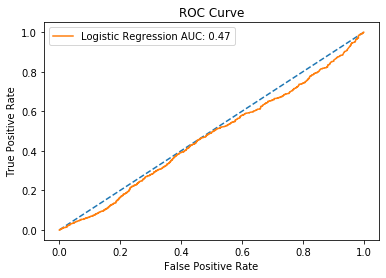

In [383]:
plot_roc(Y_test, probs[:-1], 'Logistic Regression')

In [388]:
submission['Prediction'] = probs_log
probs_log

array([0.00214846, 0.00209533, 0.00217554, ..., 0.00457429, 0.00482303,
       0.0051158 ])

In [389]:
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.002148
1,S01_Sess01_FB002,0.002095
2,S01_Sess01_FB003,0.002176
3,S01_Sess01_FB004,0.002392
4,S01_Sess01_FB005,0.002460
...,...,...
3395,S25_Sess05_FB096,0.004643
3396,S25_Sess05_FB097,0.004316
3397,S25_Sess05_FB098,0.004574
3398,S25_Sess05_FB099,0.004823


In [390]:
submission['Prediction'] = probs_log
submission.to_csv('submission_log.csv', index=None)

In [350]:
probs_log

array([0.53498896, 0.58768334, 0.60901913, ..., 0.31996724, 0.61704042,
       0.59113877])

## Support Vector Machines

took 25+ minutes to run so I stopped it

In [21]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.2)
scaler = StandardScaler()

In [27]:
start = time.time()

svclassifier = SVC(kernel='linear')
svclassifier.fit(scaler.fit_transform(x_train1), y_train1)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 30 seconds


In [269]:
svm_preds = svclassifier.predict(scaler.transform(x_test1))
svm_preds

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

max(tpr - fpr) w/ th =  0.6933333333333334


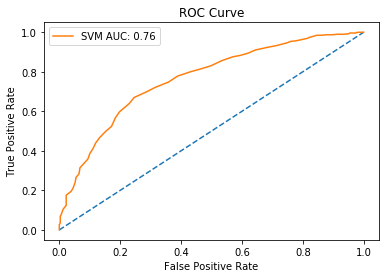

In [270]:
plot_roc(y_test1, preds, 'SVM')

In [271]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(scaler.fit_transform(X_train), Y_train)
now = time.time()

In [273]:
svm_preds = svclassifier.predict(scaler.transform(X_test))

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
params = {
    'C': [0.1, 0.5, 1, 5], 
    'kernel': ['rbf'], 
    'degree': [2, 3, 7, 10],
    'gamma': np.power(5, np.linspace(-2,5, 10)),
    'max_iter': [100000]
}

In [24]:
svc = SVC()
cv = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=20, refit='accuracy', cv=4)

In [ ]:
cv.fit(scaler.fit_transform(X_train), Y_train)

Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 10.3min
[Paralle

## ElasticNet

In [321]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.4)
en.fit(X_train, Y_train)
probs = en.predict(X_test)

In [322]:
probs

array([0.241065  , 0.28015385, 0.31672244, ..., 0.11610575, 0.30081757,
       0.27199328])

max(tpr - fpr) w/ th =  0.6610885969333447


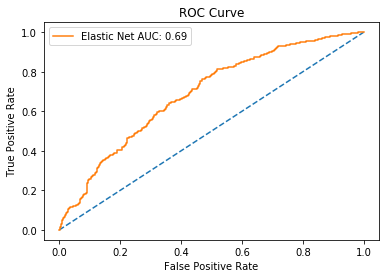

In [320]:
plot_roc(test_y, probs, 'Elastic Net')

In [323]:
probs.shape

(3400,)

In [25]:
y_test1.shape

(1088,)

In [26]:
matrix_info(0.6968 ,y_test1, probs)

f1_score:
0.7367636092468307
Confusion Matrix:
[[241  77]
 [276 494]]
              precision    recall  f1-score   support

           0       0.47      0.76      0.58       318
           1       0.87      0.64      0.74       770

    accuracy                           0.68      1088
   macro avg       0.67      0.70      0.66      1088
weighted avg       0.75      0.68      0.69      1088



In [326]:
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.241065
1,S01_Sess01_FB002,0.280154
2,S01_Sess01_FB003,0.316722
3,S01_Sess01_FB004,0.264452
4,S01_Sess01_FB005,0.335727
...,...,...
3395,S25_Sess05_FB096,0.318724
3396,S25_Sess05_FB097,0.294933
3397,S25_Sess05_FB098,0.116106
3398,S25_Sess05_FB099,0.300818


In [325]:
submission['Prediction'] = probs

In [335]:
submission.Predicition = probs
submission.to_csv('submission.csv', index=None)

In [63]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
         'l1_ratio': [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         'normalize': ['True', 'False']}

In [64]:
en = ElasticNet()
cv = GridSearchCV(en, param_grid=params, n_jobs=-1, verbose=10, cv=5)
cv.fit(X_train, Y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [65]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize': 'True'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.211751,0.020478,0.002168,0.001929,0.0001,0.4,True,"{'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize'...",0.037230,0.023280,0.159506,0.078458,0.104450,0.080585,0.048921,1
9,0.222357,0.020918,0.003768,0.002386,0.0001,0.4,False,"{'alpha': 0.0001, 'l1_ratio': 0.4, 'normalize'...",0.037230,0.023280,0.159506,0.078458,0.104450,0.080585,0.048921,1
6,0.215182,0.020946,0.003443,0.002882,0.0001,0.3,True,"{'alpha': 0.0001, 'l1_ratio': 0.3, 'normalize'...",0.037882,0.022799,0.159975,0.078381,0.103844,0.080576,0.049013,3
7,0.220973,0.015497,0.003076,0.002333,0.0001,0.3,False,"{'alpha': 0.0001, 'l1_ratio': 0.3, 'normalize'...",0.037882,0.022799,0.159975,0.078381,0.103844,0.080576,0.049013,3
4,0.229698,0.019176,0.003762,0.002571,0.0001,0.2,True,"{'alpha': 0.0001, 'l1_ratio': 0.2, 'normalize'...",0.038548,0.022216,0.159973,0.078667,0.103270,0.080534,0.048979,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.192397,0.046575,0.004844,0.001647,0.1,0.5,False,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.138524,-0.103251,-0.013623,-0.153030,-0.025915,-0.086869,0.057261,53
70,0.218621,0.047091,0.011385,0.014770,0.1,0.5,True,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.138524,-0.103251,-0.013623,-0.153030,-0.025915,-0.086869,0.057261,53
138,0.116025,0.007159,0.003573,0.001928,100,0.9,True,"{'alpha': 100, 'l1_ratio': 0.9, 'normalize': '...",-0.138524,-0.103251,-0.013623,-0.153030,-0.025915,-0.086869,0.057261,53
78,0.203768,0.037306,0.004959,0.003633,0.1,0.9,True,"{'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': '...",-0.138524,-0.103251,-0.013623,-0.153030,-0.025915,-0.086869,0.057261,53


In [395]:
en = ElasticNet()
en.fit(X_train, Y_train)
probs_en = en.predict(X_test)

In [396]:
probs_en

array([0.70772059, 0.70772059, 0.70772059, ..., 0.70772059, 0.70772059,
       0.70772059])

max(tpr - fpr) w/ th =  1.7077205882352942


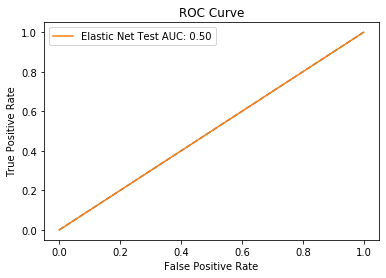

In [394]:
plot_roc(Y_test, probs_en[:-1], 'Elastic Net Test')

In [397]:
submission['Prediction'] = probs_en
submission.to_csv('submission_elastic.csv', index=None)

## LDA

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [328]:
lda = LDA(solver = 'svd', n_components=None)
lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [330]:
probs = lda.predict_proba(X_test)[:,1]

In [331]:
plot_roc(Y_test, probs, 'LDA')

ValueError: Found input variables with inconsistent numbers of samples: [3399, 3400]

In [96]:
params = {
    'solver': ['svd','lsqr','eigen'],
    'n_components' : [5,10,15,20,25,30,35,None]
}

In [117]:
params = {
    'solver': ['lsqr','eigen'],
    'shrinkage' : [None, 'auto'],
    'n_components' : [5,10,15,20,25,30,35,None]
}

In [93]:
train_x, train_y, test_x, test_y = extract_sub(df_X, 15)

In [128]:
lda = LDA()
cv = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=10, cv=5)
cv.fit(X_train1, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   12.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.8s finished
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_featur

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=-1,
             param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35, None],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [129]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][1])
cv_results.sort_values('rank_test_score')

best params:  {'n_components': None, 'solver': 'svd'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.707655,0.030506,0.002096,0.000371,5,svd,"{'n_components': 5, 'solver': 'svd'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
21,0.665033,0.043530,0.002087,0.000811,None,svd,"{'n_components': None, 'solver': 'svd'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
20,0.497126,0.033817,0.003093,0.002072,35,eigen,"{'n_components': 35, 'solver': 'eigen'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
19,0.466888,0.048365,0.002900,0.001337,35,lsqr,"{'n_components': 35, 'solver': 'lsqr'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
18,0.681029,0.027579,0.002445,0.000831,35,svd,"{'n_components': 35, 'solver': 'svd'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
17,0.476009,0.022399,0.002190,0.000730,30,eigen,"{'n_components': 30, 'solver': 'eigen'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
16,0.485497,0.017946,0.002037,0.000597,30,lsqr,"{'n_components': 30, 'solver': 'lsqr'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
15,0.674700,0.037600,0.002172,0.000416,30,svd,"{'n_components': 30, 'solver': 'svd'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
14,0.479337,0.025784,0.001441,0.000494,25,eigen,"{'n_components': 25, 'solver': 'eigen'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1
13,0.472009,0.042937,0.001414,0.000474,25,lsqr,"{'n_components': 25, 'solver': 'lsqr'}",0.671875,0.492647,0.539522,0.684743,0.591912,0.59614,0.07419,1


In [ ]:
{'n_components': None, 'solver': 'svd'}

In [99]:
lda = LDA(solver = 'svd', n_components=None)
lda.fit(train_x, train_y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [102]:
probs = lda.predict_proba(test_x)[:,1]

max(tpr - fpr) w/ th =  0.6136490062137726


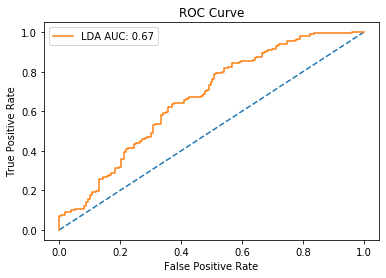

In [104]:
plot_roc(test_y, probs, 'LDA')

In [332]:
lda = LDA(solver = 'svd', n_components=None)
lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [333]:
probs = lda.predict_proba(X_test)[:,1]

max(tpr - fpr) w/ th =  0.0004976943651162147


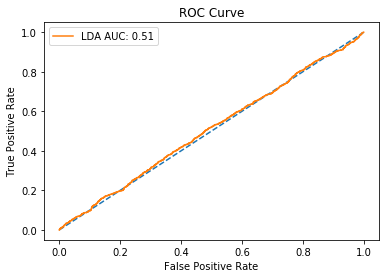

In [334]:
plot_roc(Y_test, probs[:-1], 'LDA')

In [336]:
probs

array([0.0004257 , 0.00132605, 0.00189334, ..., 0.00014405, 0.0010585 ,
       0.00124913])

In [ ]:
submission.Predicition = probs
submission.to_csv('submission.csv', index=None)

In [338]:
from sklearn.svm import LinearSVC as LSVC
from sklearn.calibration import CalibratedClassifierCV

In [339]:
start = time.time()
svc = LSVC(C = 3, loss = 'hinge', max_iter=10000)
svc = CalibratedClassifierCV(svc)
svc.fit(x_train1,y_train1)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

probs_svm = svc.predict_proba(x_test1)[:,1]

NameError: name 'x_train1' is not defined

max(tpr - fpr) w/ th =  0.6465348176793951


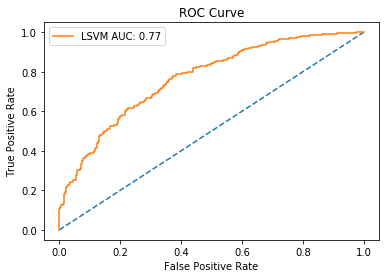

In [79]:
plot_roc(y_test1, probs_svm, 'LSVM')

In [340]:
start = time.time()
svc = LSVC(C = 3, loss = 'hinge', max_iter=10000)
svc = CalibratedClassifierCV(svc, cv = 5)
svc.fit(X_train,Y_train)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

probs_svm = svc.predict_proba(X_test)[:,1]

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Elapsed Time: 27 seconds


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


max(tpr - fpr) w/ th =  0.08577431652202673


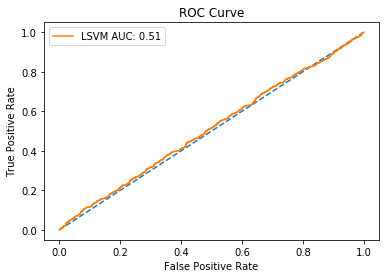

In [341]:
plot_roc(Y_test, probs_svm[:-1], 'LSVM')

In [343]:
submission.Predicition = probs_svm
submission.to_csv('submission_svm.csv', index=None)

In [86]:
np.unique(Y_train, return_counts=True)

(array([0, 1], dtype=int64), array([1590, 3850], dtype=int64))

In [84]:
np.unique(Y_test,return_counts=True)accuracy = sum(probs == y_test1) / len(y_test1)

(array([0, 1], dtype=int64), array([ 989, 2410], dtype=int64))

# Decision Tree

In [24]:
from sklearn import tree

In [67]:
dt = tree.DecisionTreeClassifier().fit(train_x, train_y)

In [68]:
pred = dt.predict(test_x)

In [69]:
accuracy = sum(pred == test_y) / len(test_y)
print(accuracy)

0.638235294117647


In [70]:
def plot_roc(y, preds, model):
    fpr, tpr, thresholds = roc_curve(y, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("max(tpr - fpr) w/ th = ", optimal_threshold)
    l1, = plt.plot([0, 1], [0, 1], '--')
    l2, = plt.plot(fpr, tpr, label = model)
    auc = roc_auc_score(y, preds)
    l = plt.legend([l2], [model+str(' AUC: %.2f' % auc)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

max(tpr - fpr) w/ th =  1.0


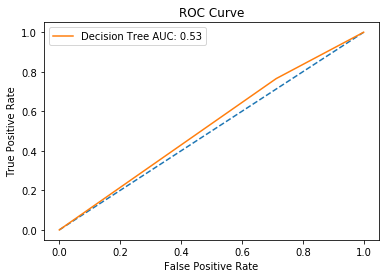

In [73]:
plot_roc(test_y, pred, 'Decision Tree')

In [74]:
def matrix_info(y, preds):
    print('f1_score:')
    print(f1_score(y, preds))
    print('Confusion Matrix:')
    print(confusion_matrix(y,preds))
    print(classification_report(y,preds))

In [75]:
matrix_info(test_y, pred)

f1_score:
0.7564356435643564
Confusion Matrix:
[[104 258]
 [234 764]]
              precision    recall  f1-score   support

         0.0       0.31      0.29      0.30       362
         1.0       0.75      0.77      0.76       998

    accuracy                           0.64      1360
   macro avg       0.53      0.53      0.53      1360
weighted avg       0.63      0.64      0.63      1360



In [76]:
acc_list = []
pred_list =[]
for i in range(10):
    dt = tree.DecisionTreeClassifier().fit(train_x, train_y)
    pred = dt.predict(test_x)
    pred_list.append(pred)
    accuracy = sum(pred == test_y) / len(test_y)
    acc_list.append(accuracy)
print(acc_list)
print(max(acc_list))

[0.6316176470588235, 0.6448529411764706, 0.6404411764705882, 0.6264705882352941, 0.6198529411764706, 0.6110294117647059, 0.625, 0.6279411764705882, 0.6411764705882353, 0.6257352941176471]
0.6448529411764706


max(tpr - fpr) w/ th =  1.0


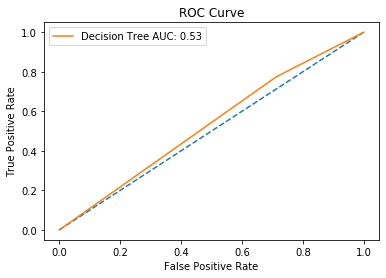

In [77]:
plot_roc(test_y, pred_list[1], 'Decision Tree')

In [78]:
matrix_info(test_y, pred_list[1])

f1_score:
0.7619517003449975
Confusion Matrix:
[[104 258]
 [225 773]]
              precision    recall  f1-score   support

         0.0       0.32      0.29      0.30       362
         1.0       0.75      0.77      0.76       998

    accuracy                           0.64      1360
   macro avg       0.53      0.53      0.53      1360
weighted avg       0.63      0.64      0.64      1360



In [79]:
acc_list_b = []
pred_list_b =[]
for i in range(10):
    dt = tree.DecisionTreeClassifier(class_weight='balanced').fit(train_x, train_y)
    pred = dt.predict(test_x)
    pred_list_b.append(pred)
    accuracy = sum(pred == test_y) / len(test_y)
    acc_list_b.append(accuracy)
print(acc_list_b)
print(max(acc_list_b))

[0.6360294117647058, 0.6411764705882353, 0.6426470588235295, 0.6536764705882353, 0.6477941176470589, 0.65, 0.6448529411764706, 0.6529411764705882, 0.6514705882352941, 0.6522058823529412]
0.6536764705882353


max(tpr - fpr) w/ th =  1.0


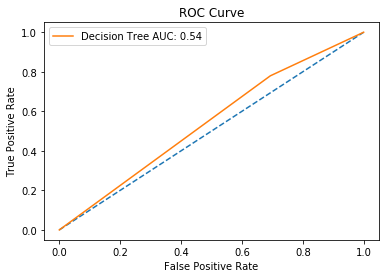

In [80]:
plot_roc(test_y, pred_list_b[3], 'Decision Tree')

In [81]:
matrix_info(test_y, pred_list_b[3])

f1_score:
0.7676369018253576
Confusion Matrix:
[[111 251]
 [220 778]]
              precision    recall  f1-score   support

         0.0       0.34      0.31      0.32       362
         1.0       0.76      0.78      0.77       998

    accuracy                           0.65      1360
   macro avg       0.55      0.54      0.54      1360
weighted avg       0.64      0.65      0.65      1360



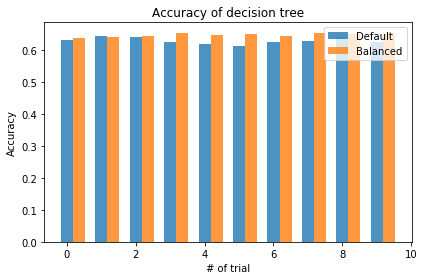

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, acc_list, bar_width,
alpha=opacity,
#color='b',
label='Default')

rects2 = plt.bar(index + bar_width, acc_list_b, bar_width,
alpha=opacity,
#color='g',
label='Balanced')

plt.xlabel('# of trial')
plt.ylabel('Accuracy')
plt.title('Accuracy of decision tree')
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

# LR

In [1]:
from sklearn.linear_model import LogisticRegression

In [100]:
clf = LogisticRegression(random_state=0, max_iter=1000, C = 0.1, penalty = 'l1').fit(train_x, train_y)
probs = clf.predict_proba(test_x)[:,1]

/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


max(tpr - fpr) w/ th =  0.6727634031322165


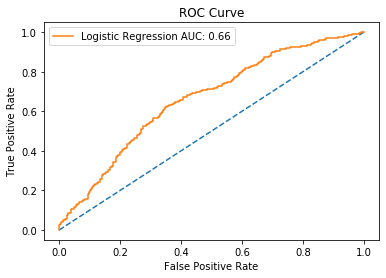

In [101]:
plot_roc(test_y, probs, 'Logistic Regression')

In [102]:
preds = clf.predict(test_x)

In [103]:
accuracy = sum(preds == test_y) / len(test_y)
print(accuracy)

0.7352941176470589


In [99]:
acc_list = []
pred_list =[]
prob_list =[]
for i in range(-2,3):
    clf = LogisticRegression(random_state=0, max_iter=1000, C = 10**i, penalty = 'l1').fit(train_x, train_y)
    prob = clf.predict_proba(test_x)[:,1]
    prob_list.append(prob)
    pred = clf.predict(test_x)
    pred_list.append(pred)
    accuracy = sum(pred == test_y) / len(test_y)
    acc_list.append(accuracy)
print(acc_list)
print(max(acc_list))

/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

[0.7161764705882353, 0.7352941176470589, 0.7264705882352941, 0.7242647058823529, 0.7227941176470588]
0.7352941176470589


In [110]:
acc_list_l2 = []
pred_list_l2 =[]
prob_list_l2 =[]
for i in range(-2,3):
    clf = LogisticRegression(random_state=0, max_iter=1000, C = 10**i, penalty = 'l2').fit(train_x, train_y)
    prob = clf.predict_proba(test_x)[:,1]
    prob_list_l2.append(prob)
    pred = clf.predict(test_x)
    pred_list_l2.append(pred)
    accuracy = sum(pred == test_y) / len(test_y)
    acc_list_l2.append(accuracy)
print(acc_list_l2)
print(max(acc_list_l2))

/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

[0.7139705882352941, 0.7279411764705882, 0.7264705882352941, 0.7235294117647059, 0.7220588235294118]
0.7279411764705882


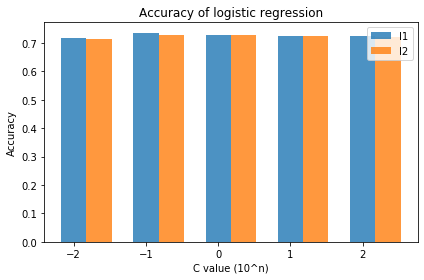

In [119]:
# create plot
fig, ax = plt.subplots()
index = np.arange(-2,3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, acc_list, bar_width,
alpha=opacity, label='l1')

rects2 = plt.bar(index + bar_width, acc_list_l2, bar_width,
alpha=opacity, label='l2')

plt.xlabel('C value (10^n)')
plt.ylabel('Accuracy')
plt.title('Accuracy of logistic regression')
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

/Users/chufan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


max(tpr - fpr) w/ th =  0.6732005408453384


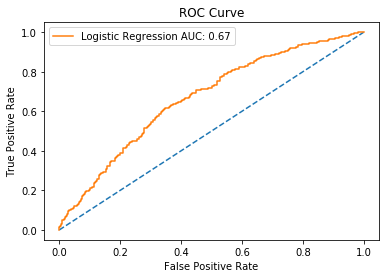

In [117]:
clf = LogisticRegression(random_state=0, max_iter=1000, C = 0.1, penalty = 'l2').fit(train_x, train_y)
probs = clf.predict_proba(test_x)[:,1]
plot_roc(test_y, probs, 'Logistic Regression')